In [1]:
import os

import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from matplotlib import pyplot as plt

sns.set()

In [2]:
# project files
from rp_model.files import set_files_directory

set_files_directory("./files")

from rp_model.calc import (
    game, FitOptions, download_data, refresh_pokedex, compute_rp, make_precomputed_columns, make_initial_guess
)
from rp_model.utils import (
    pack, unpack, simplify_opt_result, table, progressive_soft_round_loop, RoundApprox, DataStore
)

RP model file path: C:\Users\jckin\Documents\Untitled Folder\RP fit\files


In [3]:
# stuff for display

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 120)

In [4]:
refresh_rp_file = True

if refresh_rp_file:
    refresh_pokedex()
    data = download_data()
    data.to_pickle(FitOptions.data_file)
else:
    data = pd.read_pickle(FitOptions.data_file)

In [5]:
data.describe()
data.head()

,Level,RP,MS lvl,ModelRP,Difference,Freq1,FreqL,Inv,Berry1,BerryL,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,BerryD,IngD,Dupes,Amnt,Ing2P,Help skill bonus,RP Multiplier
count,9117.000000,9117.000000,9117.000000,9117.000000,9117.000000,9117.000000,9117.00000,9117.000000,9117.000000,9117.000000,9117.000000,9117.000000,9117.000000,9117.00000,9117.000000,9117.000000,9117.000000,9117.000000,9117.000000,9117.000000,9117.0,9117.000000,9117.000000,9117.000000,9117.000000
mean,12.659098,704.845124,1.605024,704.714599,-0.024789,3818.350335,3645.04663,12.736536,28.086322,40.005265,108.773829,1.073889,0.987125,0.99413,0.999671,1.007086,0.209328,36.251303,59.451026,151.427443,1.0,0.164637,7.109246,0.983669,1.034951
std,8.473861,491.617403,1.082931,491.680089,1.496317,993.493532,1061.27795,3.653443,2.609747,9.783594,15.965998,0.331260,0.058230,0.04484,0.118957,0.119373,0.047127,41.485268,31.517109,66.273504,0.0,0.746344,31.420654,0.042780,0.076927
min,1.000000,245.000000,1.000000,-1.000000,-17.000000,2200.000000,1489.11840,7.000000,24.000000,24.000000,90.000000,0.520000,0.890000,0.92000,0.800000,0.800000,0.000000,0.000000,25.000000,90.000000,1.0,0.000000,0.000000,0.790000,1.000000
25%,6.000000,374.000000,1.000000,374.000000,0.000000,3000.000000,2741.76000,10.000000,26.000000,33.000000,98.000000,0.820000,1.000000,1.00000,1.000000,1.000000,0.180000,14.100000,37.000000,101.000000,1.0,0.000000,0.000000,1.000000,1.000000
50%,11.000000,533.000000,1.000000,533.000000,0.000000,3700.000000,3557.40000,12.000000,28.000000,38.000000,103.000000,1.010000,1.000000,1.00000,1.000000,1.000000,0.210000,20.750000,50.000000,121.000000,1.0,0.000000,0.000000,1.000000,1.000000
75%,17.000000,824.000000,2.000000,824.000000,0.000000,4400.000000,4373.60000,15.000000,31.000000,44.000000,115.000000,1.310000,1.000000,1.00000,1.000000,1.000000,0.230000,47.700000,72.000000,202.000000,1.0,0.000000,0.000000,1.000000,1.000000
max,50.000000,5217.000000,6.000000,5220.000000,128.000000,6300.000000,6916.14000,25.000000,35.000000,107.000000,151.000000,2.410000,1.120000,1.08000,1.200000,1.200000,0.430000,414.490000,321.000000,511.000000,1.0,8.000000,342.000000,1.000000,1.440000


,Pokemon,Level,RP,Nature,MS lvl,Source,ModelRP,Difference,Nature2,ID,NatureP,NatureN,Freq1,FreqL,Type,Class,MSkill,Inv,Berry1,BerryL,Ing1,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,RPneutral,IDNeutral,BerryD,IngD,Dupes,DupeMatch,Sub Skill 1,Sub Skill 2,Ingredient 2,Amnt,Ing2P,Help skill bonus,RP Multiplier,Sub Skill 3
0,Arbok,8.0,531.0,Hardy,1.0,Questions help guides,531.0,0.0,Neutral,ArbokNeutral81,-,-,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.0,1.00,1.0,1.0,0.26,22.75,531.00,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0,
1,Arbok,8.0,538.0,Quiet,1.0,Questions help guides,538.0,0.0,Quiet,ArbokQuiet81,Ingredient Finding,Exp Gains,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.0,1.00,1.2,1.0,0.26,22.75,530.61,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0,
2,Arbok,9.0,528.0,Bold,1.0,,528.0,0.0,Bold,ArbokBold91,Energy Recovery,Speed of Help,3700.0,4004.88,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,0.89,1.1,1.08,1.0,1.0,0.26,22.75,538.33,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0,
3,Arbok,9.0,539.0,Hardy,1.0,Double Jumper,539.0,0.0,Neutral,ArbokNeutral91,-,-,3700.0,3640.80,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,0.98,1.0,1.00,1.0,1.0,0.26,22.75,539.00,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0,
4,Arbok,9.0,574.0,Naughty,1.0,Rate My Mon,574.0,0.0,Naughty,ArbokNaughty91,Speed of Help,Main Skill Chance,3700.0,3276.72,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,1.09,0.9,1.00,1.0,0.8,0.26,22.75,538.35,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0,


In [7]:
FitOptions.rounding.final_rp = RoundApprox.Pass
FitOptions.rounding.bonus = RoundApprox.Exact
FitOptions.rounding.period = RoundApprox.Pass
FitOptions.rounding.components = RoundApprox.Pass


In [8]:
# Make an initial guess
# Pack the dictionary into a 1-D vector.
# Also store information on how to unpack that vector

x0, unpack_info = pack(*make_initial_guess())


In [9]:
# Compute per sample information about help time, nature, subskills etc
computed = make_precomputed_columns(data)

# Do we match the sheet? Yes
(computed.helps_per_hour - data["Helps per hour"]).describe()

count    9.117000e+03
mean     2.396533e-17
std      6.016548e-17
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.440892e-16
Name: Helps per hour, dtype: float64

In [10]:
# We compute the RP model in rp_model.py
# Here we create closure to glue the pieces together.

def RP(x):
    return compute_rp(x, data, computed, unpack_info)


def residual(x):
    return data["RP"].to_numpy() - RP(x)

count    9117.000000
mean       -1.000658
std         3.658107
min      -128.000000
25%        -1.000000
50%        -1.000000
75%         0.000000
max       297.000000
Name: RP, dtype: float64

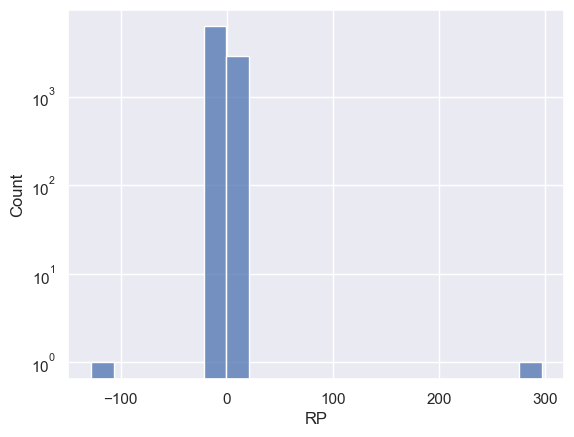

In [11]:
# what is the quality of the initial guess?

r = data["RP"] - np.round(RP(x0))
pd.Series(r).describe()

# _ = plt.figure()
# g = sns.histplot(x=np.clip(np.abs(r), 1e-1,1e3), log_scale=True, bins=20)
# g.axes.set_yscale('log')
# _ = g.bar_label(g.containers[1], labels= [str(v) if v else '' for v in g.containers[1].datavalues])

_ = plt.figure()
g = sns.histplot(x=r, bins=20)
_ = g.axes.set_yscale('log')
#_ = g.bar_label(g.containers[1], labels=[str(v) if v else '' for v in g.containers[1].datavalues])

In [12]:
cache_fit = True

# least_squares gives a deterministic result that depends on x0, the data, and the optimizer options
# hash the data as well as x0 to decide if we reuse last fit

store = (DataStore()
         .with_dependency_on(data, x0)
         .try_read_and_validate(FitOptions.result_file)
         )

if cache_fit and store.is_valid() :
    opt = store.data()
    print("Loaded from cache")

else:

    opt = progressive_soft_round_loop(x0,
        lambda x: scipy.optimize.least_squares(residual, x, **FitOptions.least_squares_kwargs)
    )

    # save results and remove some stuff we don't need to save.
    store.use_data(simplify_opt_result(opt)).save_to(FitOptions.result_file)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6881e+04                                    1.18e+07    
       1              3         9.5516e+03      7.33e+03       2.17e+00       1.61e+06    
       2              7         7.4714e+03      2.08e+03       3.39e-02       1.34e+06    
       3              8         6.7542e+03      7.17e+02       3.39e-02       5.04e+05    
       4              9         6.5583e+03      1.96e+02       3.39e-02       3.14e+03    
       5             10         6.3398e+03      2.18e+02       6.77e-02       3.14e+03    
       6             11         5.9105e+03      4.29e+02       1.35e-01       3.14e+03    
       7             12         5.0549e+03      8.56e+02       2.71e-01       3.14e+03    
       8             13         3.3458e+03      1.71e+03       5.42e-01       3.14e+03    
       9             15         3.1466e+03      1.99e+02       2.71e-01       4.31e+03    

In [13]:
opt

    message: `ftol` termination condition is satisfied.
    success: True
     status: 2
          x: [ 5.613e-01  5.443e-01 ...  3.682e-01  3.698e-01]
       cost: 2812.431265371763
       grad: [-2.534e-04 -1.050e-04 ...  0.000e+00  0.000e+00]
 optimality: 0.0099621197726453
       nfev: 36
       njev: 23

count    9117.000000
mean       -0.008555
std         1.344766
min      -114.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        17.000000
Name: RP, dtype: float64

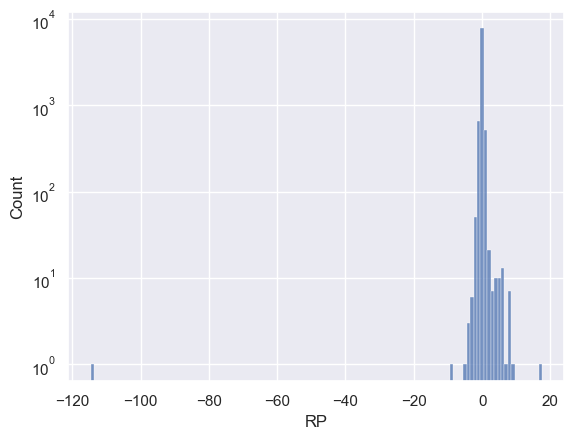

In [14]:
r_opt = data["RP"] - np.round(RP(opt.x))
pd.Series(r_opt).describe()

# _ = plt.figure()
# g = sns.histplot(x=np.clip(np.abs(r_opt), 1e-1,1e3), log_scale=True, bins=20)
# g.axes.set_yscale('log')
# _ = g.bar_label(g.containers[1], labels= [str(v) if v else '' for v in g.containers[1].datavalues])

_ = plt.figure()
g = sns.histplot(x=r_opt, discrete=1)
_ = g.axes.set_yscale('log')
#_ = g.bar_label(g.containers[1], labels=[str(v) if v else '' for v in g.containers[1].datavalues])


In [15]:
sol = unpack(opt.x, unpack_info)
table(sol)

Pokemons ing fractions,[0.25613144 0.25443399 0.2654417 ... 0.20568306 0.21866491 0.17941456]
Pokemons skill products,[16.70851548 16.70341095 18.46563705 ... 51.90099546 55.40773091 44.70848102]
Charge Strength S,[0.74658943 0.32247334]
Charge Strength M,[0.74514533 0.32271793]
Ingredient Magnet S,[0.74558283 0.3227048 ]
Cooking Power-Up S,[0.7448458 0.32291 ]
Extra Helpful S,[0.74610103 0.32232814]
Charge Energy S,[0.74640569 0.32244406]
Energizing Cheer S,[0.74635312 0.32212441]
Energy for Everyone S,[0.74561101 0.32268588]
Dream Shard Magnet S,[0.74681448 0.32193621]


In [16]:
# Format ing% and skillProduct pretty

res = pd.DataFrame({
    "Pokemon": game.data.pokedex["Pokemon"], "ing%": sol["Pokemons ing fractions"] * 100.0,
    "skill% * skillValue": sol["Pokemons skill products"]
})
res.set_index("Pokemon")

,ing%,skill% * skillValue
Pokemon,,
Bulbasaur,25.613144,16.708515
Ivysaur,25.443399,16.703411
Venusaur,26.544170,18.465637
Charmander,20.028567,9.674816
Charmeleon,22.670589,14.041457
Charizard,22.338800,14.090095
Squirtle,26.996462,17.603312
Wartortle,27.036388,17.582856
Blastoise,27.410576,18.460235


In [17]:
# Format main skill growth per level 

growth_display = {}
levels = np.array(list(range(2, 7)))
growth_display["Level"] = levels

for record in game.data.mainskills.to_dict(orient='records'):

    skillname = record["Skill"]
    params = sol[skillname]
    growth_display[skillname] = params[0] * np.exp(params[1] * levels)

df = pd.DataFrame(growth_display)
df.set_index("Level")


,Charge Strength S,Charge Strength M,Ingredient Magnet S,Cooking Power-Up S,Extra Helpful S,Charge Energy S,Energizing Cheer S,Energy for Everyone S,Dream Shard Magnet S,Metronome
Level,,,,,,,,,,
2,1.422914,1.420856,1.421653,1.420831,1.421570,1.422480,1.421471,1.421653,1.421815,1.421797
3,1.964387,1.962026,1.963101,1.962368,1.962247,1.963731,1.961710,1.963064,1.961815,1.963324
4,2.711911,2.709315,2.710763,2.710307,2.708563,2.710926,2.707271,2.710660,2.706906,2.711104
5,3.743896,3.741227,3.743178,3.743316,3.738732,3.742427,3.736187,3.742965,3.734980,3.743695
6,5.168591,5.166170,5.168796,5.170048,5.160712,5.166412,5.156149,5.168404,5.153514,5.169574


In [18]:
# What are the worst points?

df = data[["Pokemon", "ID", "Level", "MS lvl", "NatureP", "NatureN", "Sub Skill 1", "Sub Skill 2", "RP"]].copy()

df["fit"] = RP(opt.x)
df["error"] = data["RP"] - np.round(RP(opt.x))
df["error2"] = df["error"] ** 2

df = df.sort_values("error2", ascending=False).reset_index(drop=True)
df.head(100)

,Pokemon,ID,Level,MS lvl,NatureP,NatureN,Sub Skill 1,Sub Skill 2,RP,fit,error,error2
0,Onix,OnixGentle183Skill Level Up M,18.0,3.0,Main Skill Chance,Energy Recovery,Skill Level Up M,,674.0,788.290644,-114.0,12996.0
1,Glaceon,GlaceonNeutral276Skill Level Up MHelping Speed M,27.0,6.0,-,-,Skill Level Up M,Helping Speed M,2485.0,2467.728034,17.0,289.0
2,Slaking,SlakingGentle271Inventory Up LDream Shard Bonus,27.0,1.0,Main Skill Chance,Energy Recovery,Inventory Up L,Dream Shard Bonus,1188.0,1197.292436,-9.0,81.0
3,Typhlosion,TyphlosionCareful273Berry Finding SHelping Spe...,27.0,3.0,Main Skill Chance,Ingredient Finding,Berry Finding S,Helping Speed M,1761.0,1751.768059,9.0,81.0
4,Sylveon,SylveonRelaxed102Helping Bonus,10.0,2.0,Energy Recovery,EXP Gains,Helping Bonus,,1023.0,1015.332673,8.0,64.0
5,Charizard,CharizardMild276Skill Level Up MHelping Speed M,27.0,6.0,Ingredient Finding,Energy Recovery,Skill Level Up M,Helping Speed M,1514.0,1506.461390,8.0,64.0
6,Raichu,RaichuNaughty313Helping Speed SInventory Up S,31.0,3.0,Speed of Help,Main Skill Chance,Helping Speed S,Inventory Up S,1663.0,1654.564500,8.0,64.0
7,Togekiss,TogekissGentle103Skill Trigger M,10.0,3.0,Main Skill Chance,Energy Recovery,Skill Trigger M,,1282.0,1273.573320,8.0,64.0
8,Charizard,CharizardRash273Helping BonusHelping Speed M,27.0,3.0,Ingredient Finding,Main Skill Chance,Helping Bonus,Helping Speed M,1440.0,1431.727984,8.0,64.0
9,Charizard,CharizardNeutral273Berry Finding SHelping Speed M,27.0,3.0,-,-,Berry Finding S,Helping Speed M,1528.0,1519.763117,8.0,64.0
